Loading Credit Card Fraud Dataset...
Dataset shape: (284807, 31)
Fraud rate: 0.173%

Data splits:
  Train: 199,478 samples (0.172% fraud)
  Val:   42,607 samples (0.174% fraud)
  Test:  42,722 samples (0.173% fraud)

Sample batch fraud rate: 50.8% (target: ~50%)

Device: cuda
Model parameters: 15,297
Input features: 30

Starting training...
Epoch | Train Loss |   Val Loss |       F1 |   Recall |  Precision
----------------------------------------------------------------------
    1 |     0.0655 |     0.0066 |   0.1138 |   0.9324 |     0.0606
      ✓ New best model saved (F1: 0.1138)
    2 |     0.0220 |     0.0069 |   0.0878 |   0.9324 |     0.0461
    3 |     0.0144 |     0.0055 |   0.1242 |   0.9324 |     0.0665
      ✓ New best model saved (F1: 0.1242)
    4 |     0.0104 |     0.0050 |   0.1574 |   0.9324 |     0.0859
      ✓ New best model saved (F1: 0.1574)
    5 |     0.0079 |     0.0051 |   0.1629 |   0.9324 |     0.0893
      ✓ New best model saved (F1: 0.1629)
    6 |     0.00

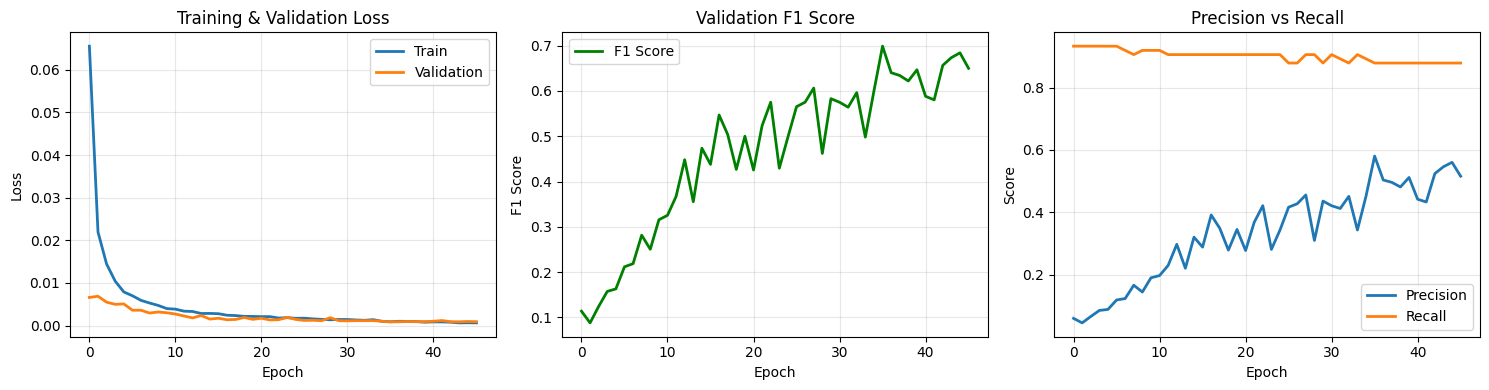

✓ Training curves saved

TEST SET EVALUATION

Probability range: 0.0571 to 1.0000
Probability mean: 0.0604
Probability std: 0.0466

THRESHOLD OPTIMIZATION

Thresh   Precision    Recall     F1         TP       FP         FN      
---------------------------------------------------------------------------
0.1      0.2033       0.8378     0.3272     62       243        12      
0.2      0.3212       0.8378     0.4644     62       131        12      
0.3      0.3924       0.8378     0.5345     62       96         12      
0.4      0.4429       0.8378     0.5794     62       78         12      
0.5      0.4839       0.8108     0.6061     60       64         14      
0.6      0.5405       0.8108     0.6486     60       51         14      
0.7      0.6122       0.8108     0.6977     60       38         14      
0.8      0.6593       0.8108     0.7273     60       31         14      
0.9      0.8000       0.8108     0.8054     60       15         14      

✓ Optimal Threshold: 0.9
  Precision:

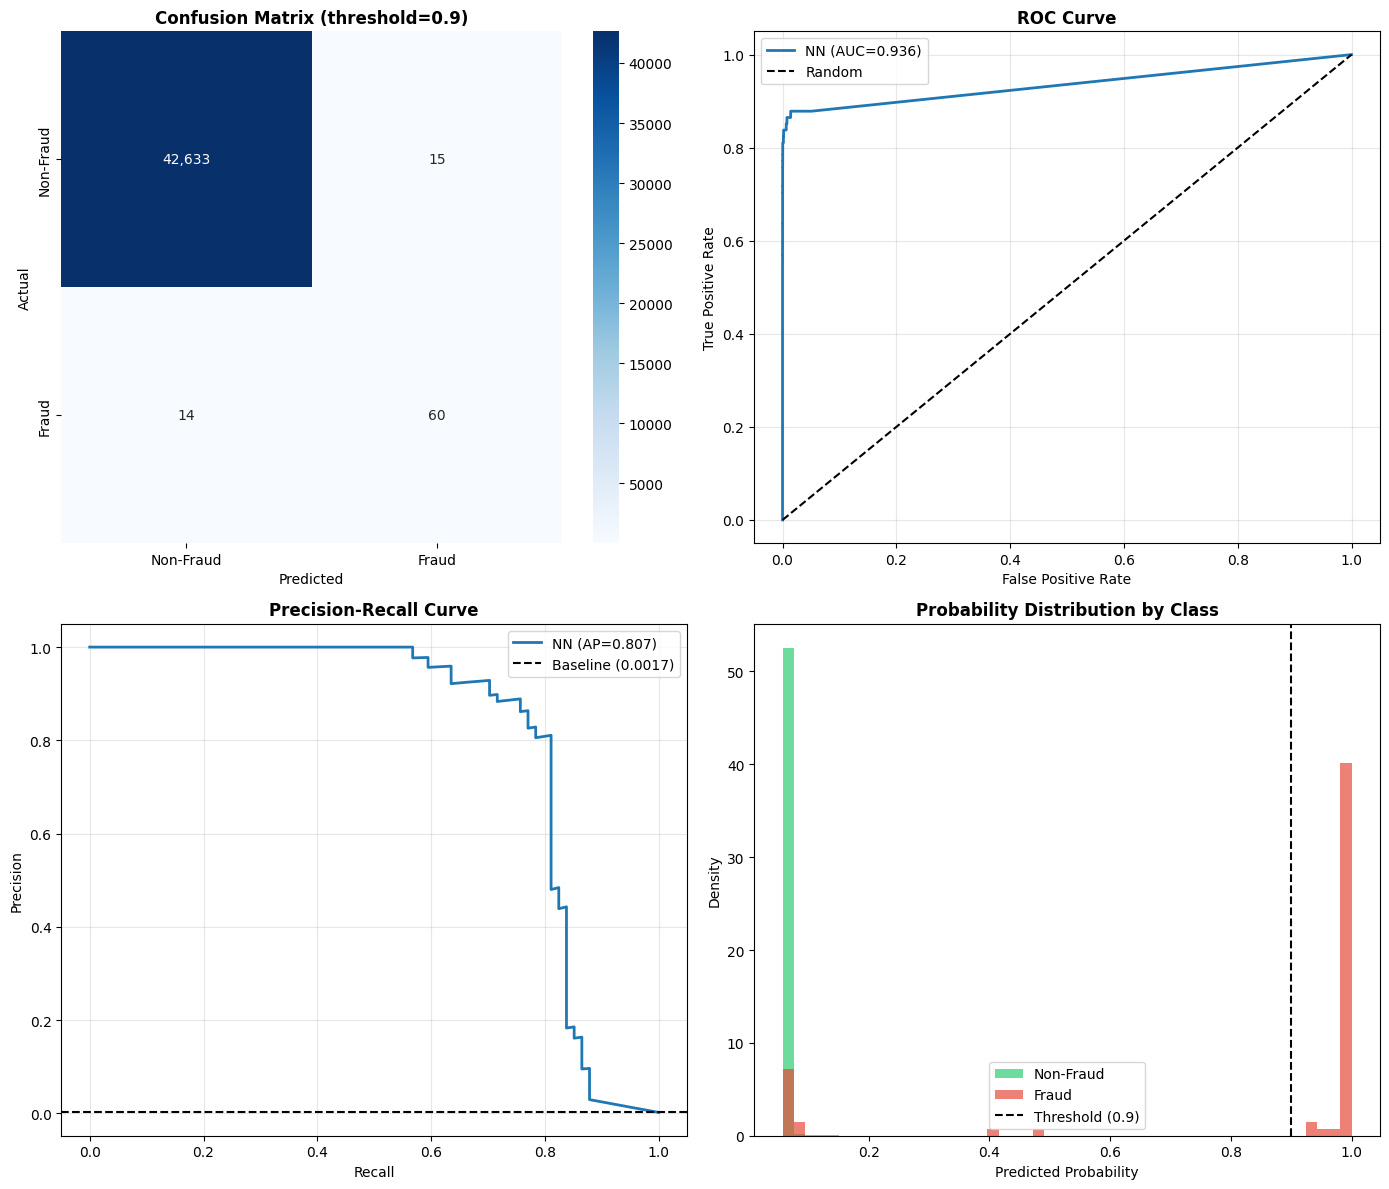


NEURAL NETWORK RESULTS SUMMARY

Model: Neural Network
Dataset: Primary (Credit Card Fraud)

Performance Metrics:
- ROC-AUC: 0.9356
- PR-AUC: 0.8070
- Best F1: 0.8054
- Precision: 0.8000 (80.0%)
- Recall: 0.8108 (81.1%)
- Optimal Threshold: 0.9

Training:
- Time: 76.3 seconds
- Best Epoch: 36

Files Saved:
- Model: ../models/primary/nn_best_model.pth
- Scaler: ../models/primary/scaler.pkl
- Results: ../models/primary/nn_results.pkl
- Training curves: ../outputs/primary/neural_network/training_curves.png
- Evaluation: ../outputs/primary/neural_network/evaluation_results.png



In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# ===== 1. LOAD DATA =====
print("Loading Credit Card Fraud Dataset...")
df = pd.read_csv('../data/primary/creditcard.csv')

print(f"Dataset shape: {df.shape}")
print(f"Fraud rate: {df['Class'].mean()*100:.3f}%")

# ===== 2. PREPARE FEATURES AND TARGET =====
X = df.drop('Class', axis=1)
y = df['Class']

# ===== 3. TRAIN/VAL/TEST SPLIT =====
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nData splits:")
print(f"  Train: {X_train.shape[0]:,} samples ({y_train.mean()*100:.3f}% fraud)")
print(f"  Val:   {X_val.shape[0]:,} samples ({y_val.mean()*100:.3f}% fraud)")
print(f"  Test:  {X_test.shape[0]:,} samples ({y_test.mean()*100:.3f}% fraud)")

# ===== 4. SCALE FEATURES =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save scaler
with open('../models/primary/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# ===== 5. PYTORCH DATASET =====
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values if hasattr(y, 'values') else y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ===== 6. CREATE WEIGHTED SAMPLER =====
y_train_np = y_train.values
class_counts = np.bincount(y_train_np)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train_np]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create datasets and loaders
train_dataset = FraudDataset(X_train_scaled, y_train)
val_dataset = FraudDataset(X_val_scaled, y_val)
test_dataset = FraudDataset(X_test_scaled, y_test)

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Verify balanced batches
X_batch, y_batch = next(iter(train_loader))
print(f"\nSample batch fraud rate: {y_batch.mean()*100:.1f}% (target: ~50%)")

# ===== 7. MODEL ARCHITECTURE =====
class FraudDetectionNet(nn.Module):
    def __init__(self, input_size, fraud_rate=0.00173):
        super(FraudDetectionNet, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.output = nn.Linear(16, 1)
        self._init_weights(fraud_rate)

    def _init_weights(self, fraud_rate):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # Initialize output bias to prior log-odds
        prior_logit = np.log(fraud_rate / (1 - fraud_rate))
        nn.init.constant_(self.output.bias, prior_logit)

    def forward(self, x):
        x = self.network(x)
        return self.output(x)

# ===== 8. FOCAL LOSS =====
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-BCE_loss)
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        focal_weight = alpha_t * (1 - pt) ** self.gamma
        loss = focal_weight * BCE_loss
        return loss.mean()

# ===== 9. INITIALIZE MODEL =====
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fraud_rate = y_train.mean()

model = FraudDetectionNet(input_size=X_train.shape[1], fraud_rate=fraud_rate).to(DEVICE)
criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

print(f"\nDevice: {DEVICE}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input features: {X_train.shape[1]}")

# ===== 10. TRAINING LOOP =====
EPOCHS = 50
PATIENCE = 10

train_losses = []
val_losses = []
val_f1_scores = []
val_recalls = []
val_precisions = []

best_f1 = 0
patience_counter = 0

print("\nStarting training...")
print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>10} | {'F1':>8} | {'Recall':>8} | {'Precision':>10}")
print("-" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader)

    # Metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    f1 = f1_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    precision = precision_score(all_labels, all_preds, zero_division=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(f1)
    val_recalls.append(recall)
    val_precisions.append(precision)

    scheduler.step(f1)

    print(f"{epoch+1:>5} | {train_loss:>10.4f} | {val_loss:>10.4f} | {f1:>8.4f} | {recall:>8.4f} | {precision:>10.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), '../models/primary/nn_best_model.pth')
        print(f"      ✓ New best model saved (F1: {f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

training_time = time.time() - start_time
print(f"\n✓ Training complete in {training_time:.1f} seconds")
print(f"Best F1: {best_f1:.4f}")

# ===== 11. PLOT TRAINING CURVES =====
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(val_losses, label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(val_f1_scores, label='F1 Score', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation F1 Score')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(val_precisions, label='Precision', linewidth=2)
axes[2].plot(val_recalls, label='Recall', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Score')
axes[2].set_title('Precision vs Recall')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/primary/neural_network/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

# ===== 12. EVALUATE ON TEST SET =====
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

# Load best model
model.load_state_dict(torch.load('../models/primary/nn_best_model.pth', map_location=DEVICE))
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch).squeeze()
        probs = torch.sigmoid(outputs)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print(f"\nProbability range: {all_probs.min():.4f} to {all_probs.max():.4f}")
print(f"Probability mean: {all_probs.mean():.4f}")
print(f"Probability std: {all_probs.std():.4f}")

# ===== 13. THRESHOLD OPTIMIZATION =====
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for thresh in thresholds:
    preds = (all_probs >= thresh).astype(int)

    tp = ((preds == 1) & (all_labels == 1)).sum()
    fp = ((preds == 1) & (all_labels == 0)).sum()
    fn = ((preds == 0) & (all_labels == 1)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results.append({
        'threshold': thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

print(f"\n{'Thresh':<8} {'Precision':<12} {'Recall':<10} {'F1':<10} {'TP':<8} {'FP':<10} {'FN':<8}")
print("-" * 75)
for r in results:
    print(f"{r['threshold']:<8.1f} {r['precision']:<12.4f} {r['recall']:<10.4f} {r['f1']:<10.4f} {r['tp']:<8} {r['fp']:<10} {r['fn']:<8}")

best_result = max(results, key=lambda x: x['f1'])
print(f"\n✓ Optimal Threshold: {best_result['threshold']}")
print(f"  Precision: {best_result['precision']:.4f}")
print(f"  Recall: {best_result['recall']:.4f}")
print(f"  F1: {best_result['f1']:.4f}")

# ===== 14. FINAL METRICS =====
optimal_preds = (all_probs >= best_result['threshold']).astype(int)

roc_auc = roc_auc_score(all_labels, all_probs)
pr_auc = average_precision_score(all_labels, all_probs)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, optimal_preds, target_names=['Non-Fraud', 'Fraud'], digits=4))

# ===== 15. VISUALIZATIONS =====
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix
cm = confusion_matrix(all_labels, optimal_preds)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_title(f'Confusion Matrix (threshold={best_result["threshold"]})', fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'NN (AUC={roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision-Recall Curve
precisions_curve, recalls_curve, _ = precision_recall_curve(all_labels, all_probs)
axes[1, 0].plot(recalls_curve, precisions_curve, linewidth=2, label=f'NN (AP={pr_auc:.3f})')
axes[1, 0].axhline(y=all_labels.mean(), color='k', linestyle='--', label=f'Baseline ({all_labels.mean():.4f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Probability Distribution
axes[1, 1].hist(all_probs[all_labels == 0], bins=50, alpha=0.7, label='Non-Fraud', color='#2ecc71', density=True)
axes[1, 1].hist(all_probs[all_labels == 1], bins=50, alpha=0.7, label='Fraud', color='#e74c3c', density=True)
axes[1, 1].axvline(x=best_result['threshold'], color='black', linestyle='--', label=f'Threshold ({best_result["threshold"]})')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Probability Distribution by Class', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../outputs/primary/neural_network/evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 16. SAVE RESULTS =====
nn_results = {
    'model': 'Neural Network',
    'dataset': 'Primary (Credit Card)',
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'best_f1': best_result['f1'],
    'precision': best_result['precision'],
    'recall': best_result['recall'],
    'optimal_threshold': best_result['threshold'],
    'training_time': training_time
}

with open('../models/primary/nn_results.pkl', 'wb') as f:
    pickle.dump(nn_results, f)

print("\n" + "="*70)
print("NEURAL NETWORK RESULTS SUMMARY")
print("="*70)
print(f"""
Model: Neural Network
Dataset: Primary (Credit Card Fraud)

Performance Metrics:
- ROC-AUC: {roc_auc:.4f}
- PR-AUC: {pr_auc:.4f}
- Best F1: {best_result['f1']:.4f}
- Precision: {best_result['precision']:.4f} ({best_result['precision']*100:.1f}%)
- Recall: {best_result['recall']:.4f} ({best_result['recall']*100:.1f}%)
- Optimal Threshold: {best_result['threshold']}

Training:
- Time: {training_time:.1f} seconds
- Best Epoch: {len(train_losses) - patience_counter}

Files Saved:
- Model: ../models/primary/nn_best_model.pth
- Scaler: ../models/primary/scaler.pkl
- Results: ../models/primary/nn_results.pkl
- Training curves: ../outputs/primary/neural_network/training_curves.png
- Evaluation: ../outputs/primary/neural_network/evaluation_results.png
""")